<a href="https://colab.research.google.com/github/Chaeran/2023DLTeamProject/blob/main/RetinaNet_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q /content/XMLdataset.zip

In [ ]:
from IPython.utils import dir2
%cd /content/
from torch.jit import annotate
import os
import random
import numpy as np
import shutil

!mkdir test_images
!mkdir test_annotations
!mkdir images
!mkdir annotations

Dir = r'test'
fileEx = r'.xml'
annot_list = [file for file in os.listdir(Dir) if file.endswith(fileEx)]
annot_list.sort()
for annot in annot_list:
  shutil.move("/content/test/"+annot, '/content/test_annotations/'+annot)

fileEx2 = r'.jpg'
img_list = [file for file in os.listdir(Dir) if file.endswith(fileEx2)]
img_list.sort()
for img in img_list:
  shutil.move("/content/test/"+img, '/content/test_images/'+img)

Dir = r'train'
fileEx = r'.xml'
annot_list = [file for file in os.listdir(Dir) if file.endswith(fileEx)]
annot_list.sort()
#len(annot_list)
#print(annot_list[:10])
for annot in annot_list:
  shutil.move("/content/train/"+annot, '/content/annotations/'+annot)

fileEx2 = r'.jpg'
img_list = [file for file in os.listdir(Dir) if file.endswith(fileEx2)]
img_list.sort()
#print(img_list[:10])
for img in img_list:
  shutil.move("/content/train/"+img, '/content/images/'+img)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

/content
227
227
57
57


In [ ]:
#이미지 출력 확인
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "phone_texting":
        return 1
    elif obj.find('name').text == "phone_calling":
        return 2
    return 0

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image(img_path, annotation):

    img = mpimg.imread(img_path)

    fig,ax = plt.subplots(1)
    ax.imshow(img)


    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 1 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

/content
57
57
SGA2101548S0020IMG0002_jpg.rf.66fc88531c72119ba21ba1f0a58db219.xml
SGA2101548S0020IMG0002_jpg.rf.66fc88531c72119ba21ba1f0a58db219.jpg
/content/test_annotations
/content/test_images


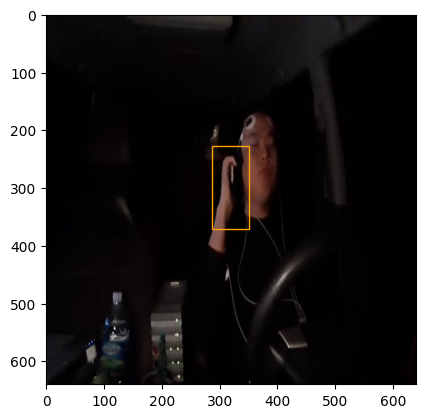

In [ ]:
%cd /content/
Dir = r'test_images'
fileEx2 = r'.jpg'
img_list = [file for file in os.listdir(Dir) if file.endswith(fileEx2)]
img_list.sort()
Dir = r'test_annotations'
fileEx = r'.xml'
annot_list = [file for file in os.listdir(Dir) if file.endswith(fileEx)]
annot_list.sort()
print(len(img_list))
print(len(annot_list))
print(annot_list[5])
print(img_list[5])

%cd /content/test_annotations//
bbox = generate_target(annot_list[15])
%cd /content/test_images/
plot_image(img_list[15], bbox)

In [ ]:
%cd /content/

/content


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os


def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "phone_texting":

        return 1

    elif obj.find('name').text == "phone_calling":

        return 2

    return 0

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 : # holding : 빨
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 1 :   #문자 : 초록

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')

        else :  #통화

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class PhoneDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)

        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = PhoneDataset('images/')
test_dataset = PhoneDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
import torchvision
import torch

In [ ]:
torchvision.__version__

'0.15.2+cu118'

In [ ]:
# 모델 불러오기
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, weights=None, weights_backbone=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
#학습
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 200
retina.to(device)

# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# epoch 당 약 40초 소요
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses
    print(f'[{epoch}]', epoch_loss, f'time: {time.time() - start}')

[0] tensor(4.5939, device='cuda:0', grad_fn=<AddBackward0>) time: 37.65619349479675
[1] tensor(4.5929, device='cuda:0', grad_fn=<AddBackward0>) time: 37.26068997383118
[2] tensor(4.5256, device='cuda:0', grad_fn=<AddBackward0>) time: 37.202569246292114
[3] tensor(5.1471, device='cuda:0', grad_fn=<AddBackward0>) time: 37.33207941055298
[4] tensor(4.9609, device='cuda:0', grad_fn=<AddBackward0>) time: 37.20696306228638
[5] tensor(4.9560, device='cuda:0', grad_fn=<AddBackward0>) time: 37.244497299194336
[6] tensor(4.5044, device='cuda:0', grad_fn=<AddBackward0>) time: 37.28687357902527
[7] tensor(4.3752, device='cuda:0', grad_fn=<AddBackward0>) time: 37.34126615524292
[8] tensor(4.5854, device='cuda:0', grad_fn=<AddBackward0>) time: 37.25441217422485
[9] tensor(4.0909, device='cuda:0', grad_fn=<AddBackward0>) time: 37.210428953170776
[10] tensor(4.3541, device='cuda:0', grad_fn=<AddBackward0>) time: 37.20524787902832
[11] tensor(4.7797, device='cuda:0', grad_fn=<AddBackward0>) time: 37.24

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs+1}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'retina_{num_epochs+1}.pt'))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
#예측
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 29/29 [00:05<00:00,  5.64it/s]


In [ ]:
import utils_ObjectDetection as utils

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

In [ ]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.8698248051628941
AP : tensor([0.7157, 0.9008, 0.9930], dtype=torch.float64)


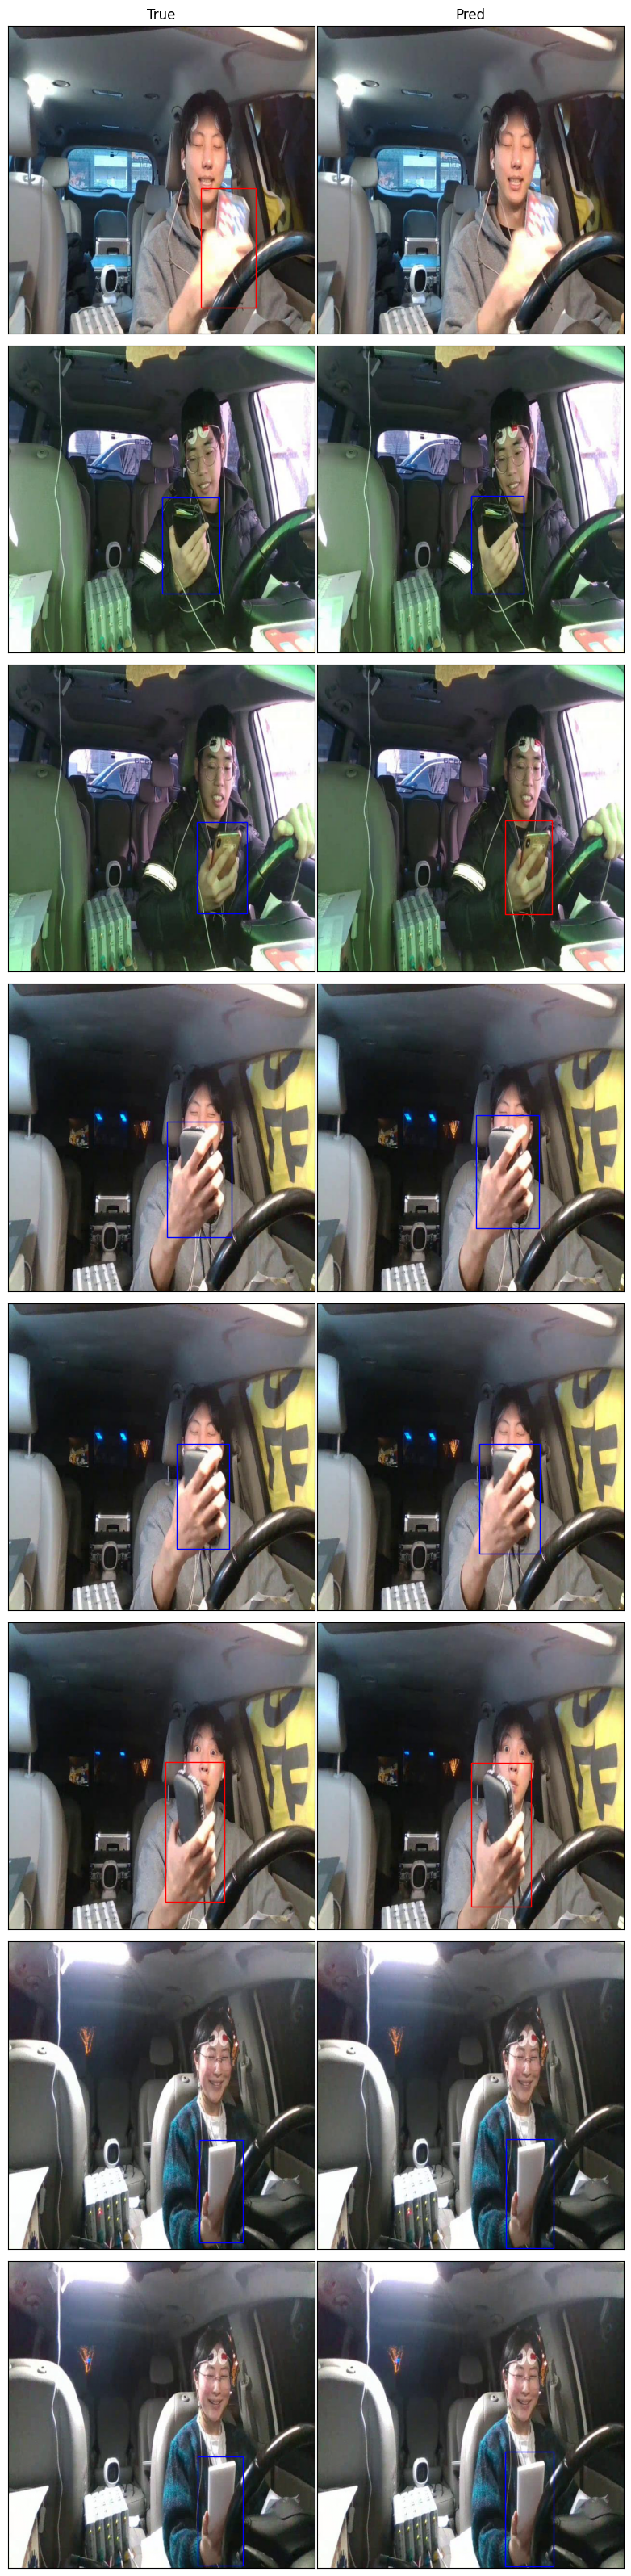

In [ ]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1 #batch_i * 4 + 1
    for sample_i in range(len(im)) :

        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2 #2

    batch_i += 1
    if batch_i == 4:#4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()